# Importing Data and create the data structure

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Split the Data to train and test

In [ ]:
import numpy as np

In [ ]:
import time
tic = time.time()
data = pd.read_csv('/content/drive/MyDrive/data/1m/ratings.csv')
toc = time.time()
print(toc - tic)

0.3935070037841797


In [ ]:
data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
len(data)

100836

In [ ]:
def user_rating():
    movie_idx_map = {}
    data_by_movie = []
    user_rating_list = []

    movie_counter = 0

    user_ids = data['userId'].tolist()
    movie_ids = data['movieId'].tolist()
    ratings = data['rating'].tolist()

    unique_user_ids = list(set(user_ids))
    user_idx_map = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}

    current_user = None
    current_user_ratings = []

    for i in range(len(data)):
        user = user_ids[i]
        movie = movie_ids[i]
        rating = ratings[i]

        if movie not in movie_idx_map:
            movie_idx_map[movie] = movie_counter
            data_by_movie.append([])
            movie_counter += 1

        movie_index = movie_idx_map[movie]
        # Store the user index instead of the user ID
        user_index = user_idx_map[user]
        data_by_movie[movie_index].append((user_index, rating))

        if user != current_user:
            if current_user is not None:
                user_rating_list.append(current_user_ratings)
            current_user_ratings = []
            current_user = user

        current_user_ratings.append((movie, rating))

    if current_user:
        user_rating_list.append(current_user_ratings)

    return user_rating_list, movie_idx_map, data_by_movie

In [ ]:
# Pass the data into user_rating_list and Movie_idx_map
import time
tic = time.time()
user_rating_list, movie_idx_map, data_by_movie = user_rating()
toc = time.time()
print(toc - tic)

0.11912417411804199


In [ ]:
len(movie_idx_map)

9724

In [ ]:
# Initialize the train and test sets
data_by_user_train = [[] for i in range(len(user_rating_list))]
data_by_movie_train = [[] for i in range(len(movie_idx_map))]

data_by_user_test = [[] for i in range(len(user_rating_list))]
data_by_movie_test = [[] for i in range(len(movie_idx_map))]

for user_idx in range(len(user_rating_list)):
    for movie_id, rating in user_rating_list[user_idx]:
        if np.random.rand() > 0.9:  # 10% test set, 90% training
            data_by_user_test[user_idx].append((movie_id, rating))
            movie_index = movie_idx_map[movie_id]
            data_by_movie_test[movie_index].append((user_idx, rating))
        else:
            # Training set
            data_by_user_train[user_idx].append((movie_id, rating))
            movie_index = movie_idx_map[movie_id]
            data_by_movie_train[movie_index].append((user_idx, rating))


In [ ]:
print(len(data_by_user_train[0]))
print(len(data_by_user_test[0]))

208
24


# compute Biases

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def compute_loss(user_rating_list, user_bias, movie_bias, movie_idx_map, lambdaa, gamma):
    total_loss = 0
    count = 0

    for user, ratings in enumerate(user_rating_list):
        for entry in ratings:
            if len(entry) == 2:
                movie_id, rating = entry
                movie_index = movie_idx_map[movie_id]
                prediction = user_bias[user] + movie_bias[movie_index]
                error = rating - prediction
                total_loss += error ** 2
                bb = (gamma / 2) * ((user_bias[user] ** 2) + (movie_bias[movie_index] ** 2))
                count += 1

    final_loss = (-((1 / 2 ) * lambdaa) * (total_loss / count)) - bb

    return final_loss

In [ ]:
def compute_rmse(user_rating_list, user_bias, movie_bias, movie_idx_map):
    total_error = 0
    total_count = 0

    for user, ratings in enumerate(user_rating_list):
        for entry in ratings:
            if len(entry) == 2:
                movie_id, rating = entry
                movie_index = movie_idx_map[movie_id]
                prediction = user_bias[user] + movie_bias[movie_index]
                error = rating - prediction
                total_error += error ** 2
                total_count += 1

    rmse = np.sqrt(total_error / total_count)

    return rmse

In [ ]:
lambdaa = 0.1
gamma = 0.03
iterations = 20

user_bias = np.random.rand(len(user_rating_list))
movie_bias = np.random.rand(len(movie_idx_map))

train_loss_values = []
train_rmse_values = []
test_loss_values = []
test_rmse_values = []

for i in range(iterations):
    for m in range(len(data_by_user_train)):
        bias = 0
        count = 0
        for entry in data_by_user_train[m]:
            if len(entry) == 2:
                movie_id, rating = entry
                if rating != 0:
                    bias += lambdaa * (rating - movie_bias[movie_idx_map[movie_id]])
                    count += 1
        if count > 0:
            bias /= (lambdaa * count + gamma)
        user_bias[m] = bias

    # Update movie biases using data_by_movie
    for movie_index, users_ratings in enumerate(data_by_movie):
        bias = 0
        count = 0
        for user, rating in users_ratings:
            if rating != 0:
                bias += lambdaa * (rating - user_bias[user])
                count += 1
        if count > 0:
            bias /= (lambdaa * count + gamma)
        movie_bias[movie_index] = bias



    loss = compute_loss(data_by_user_train, user_bias, movie_bias, movie_idx_map, lambdaa, gamma)
    rmse = compute_rmse(data_by_user_train, user_bias, movie_bias, movie_idx_map)

    test_loss = compute_loss(data_by_user_test, user_bias, movie_bias, movie_idx_map, lambdaa, gamma)
    test_rmse = compute_rmse(data_by_user_test, user_bias, movie_bias, movie_idx_map)

    train_rmse_values.append(rmse)
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)
    test_rmse_values.append(test_rmse)

    print(f"Iteration {i + 1}: Train Loss = {loss}, Test Loss = {test_loss}")
    print(f"Iteration {i + 1}: Train RMSE = {rmse}, Test RMSE = {test_rmse}")

Iteration 1: Train Loss = -0.18926366292174915, Test Loss = -0.18696034431817335
Iteration 1: Train RMSE = 0.8048522783993204, Test RMSE = 0.8125081148727472
Iteration 2: Train Loss = -0.19519348064598996, Test Loss = -0.1919354939182945
Iteration 2: Train RMSE = 0.7885094376646283, Test RMSE = 0.7966771970430033
Iteration 3: Train Loss = -0.19714603566771177, Test Loss = -0.19378089719108274
Iteration 3: Train RMSE = 0.7873966488131736, Test RMSE = 0.7955724377319735
Iteration 4: Train Loss = -0.1976913293614932, Test Loss = -0.19431529851313223
Iteration 4: Train RMSE = 0.7872589789274974, Test RMSE = 0.7954018411916066
Iteration 5: Train Loss = -0.19794326181352367, Test Loss = -0.19454838111139983
Iteration 5: Train RMSE = 0.7872255418206604, Test RMSE = 0.7953460084690345
Iteration 6: Train Loss = -0.19817189107106895, Test Loss = -0.19474518029876237
Iteration 6: Train RMSE = 0.7872126143496642, Test RMSE = 0.7953206909573994
Iteration 7: Train Loss = -0.1984177013502845, Test Lo

# Plot loss and rmse for Training and test

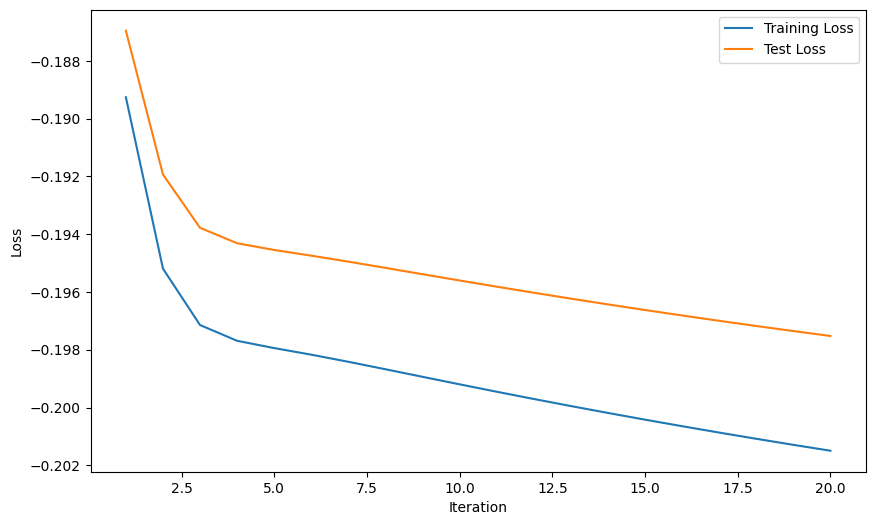

In [ ]:
# Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, iterations + 1), train_loss_values, label="Training Loss")
plt.plot(range(1, iterations + 1), test_loss_values, label="Test Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

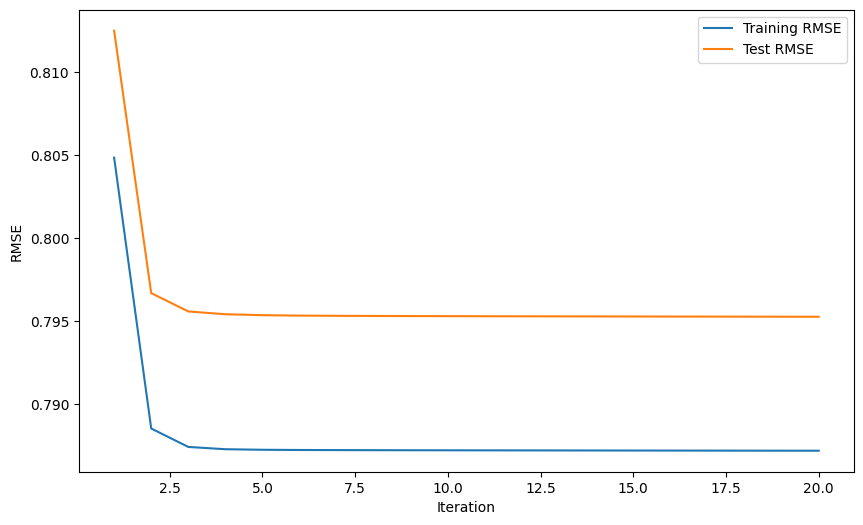

In [ ]:
# RMSE
plt.figure(figsize=(10, 6))
plt.plot(range(1, iterations + 1), train_rmse_values, label="Training RMSE")
plt.plot(range(1, iterations + 1), test_rmse_values, label="Test RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# U, V matrices

In [ ]:
def compute_loss_(user_rating_list, user_bias, movie_bias, movie_idx_map, lambdaa, gamma, U, V):
    total_loss = 0
    count = 0
    for user, ratings in enumerate(user_rating_list):
        for entry in ratings:
            if len(entry) == 2:
                movie_id, rating = entry
                movie_index = movie_idx_map[movie_id]

                prediction = user_bias[user] + movie_bias[movie_index] + np.dot(np.transpose(U[:,user]), V[:,movie_index])

                error = rating - prediction
                total_loss += error ** 2
                bb = (gamma / 2) * ((user_bias[user] ** 2) + (movie_bias[movie_index] ** 2))

                count += 1

    final_loss = (-((1 / 2 ) * lambdaa) * (total_loss / count)) - bb

    return final_loss

In [ ]:
def compute_rmse_(user_rating_list, user_bias, movie_bias, movie_idx_map, U, V):
    total_error = 0
    total_count = 0

    for user, ratings in enumerate(user_rating_list):
        for entry in ratings:
            if len(entry) == 2:
                movie_id, rating = entry
                movie_index = movie_idx_map[movie_id]

                prediction = user_bias[user] + movie_bias[movie_index] + np.dot(np.transpose(U[:,user]), V[:,movie_index])

                error = rating - prediction
                total_error += error ** 2
                total_count += 1

    if total_count == 0:
        return np.inf

    rmse = np.sqrt(total_error / total_count)

    return rmse


In [ ]:
lambdaa = 0.7
gamma = 0.1
tau = 0.9
iterations = 10
k = 7

train_loss_values_ = []
train_rmse_values_ = []
test_loss_values_ = []
test_rmse_values_ = []

user_bias = np.zeros(len(user_rating_list))
movie_bias = np.zeros(len(movie_idx_map))


U = np.random.normal(loc=0, scale=1 / np.sqrt(k), size=(k,len(user_rating_list)))
V = np.random.normal(loc=0, scale=1 / np.sqrt(k), size=(k,len(movie_idx_map)))

In [ ]:
for i in range(iterations):
    # Update User Biases
    for m in range(len(user_rating_list)):
        bias = 0
        count = 0
        for movie_id, rating in user_rating_list[m]:
            movie_idx = movie_idx_map[movie_id]
            if rating != 0:
                prediction = movie_bias[movie_idx] + np.dot(np.transpose(U[:,m]), V[:,movie_idx])
                bias += lambdaa * (rating - prediction)
                count += 1
        if count > 0:
            bias /= (lambdaa * count + tau)
        user_bias[m] = bias

        # Update User Latent Factors
        sum_1 = np.zeros(k)
        sum_2 = np.zeros((k, k))
        for movie_id, rating in user_rating_list[m]:
            movie_idx = movie_idx_map[movie_id]
            if rating != 0:
                v_n = V[:,movie_idx]
                residual = rating - (user_bias[m] + movie_bias[movie_idx] + np.dot(np.transpose(U[:,m]), v_n))
                sum_1 += v_n * residual
                sum_2 += np.outer(v_n,np.transpose(v_n))
        sum_1 = lambdaa * sum_1
        sum_2 = sum_2 + (tau * np.identity(k))
        sum_2_inv = np.linalg.inv(sum_2)
        U[:,m] = np.matmul(sum_2_inv, sum_1)

    # Update Movie Biases and Latent Factors
    for n in range(len(movie_idx_map)):
        bias = 0
        count = 0
        for user_id, rating in data_by_movie[n]:
            if rating != 0:
                prediction = user_bias[user_id] + np.dot(np.transpose(U[:,user_id]), V[:,n])
                bias += lambdaa * (rating - prediction)
                count += 1
        if count > 0:
            bias /= (lambdaa * count + tau)
        movie_bias[n] = bias

        # Update Movie Latent Factors
        sum_1 = np.zeros(k)
        sum_2 = np.zeros((k, k))
        for user_id, rating in data_by_movie[n]:
            if rating != 0:
                u_m = U[:,user_id]
                residual = rating - (user_bias[user_id] + movie_bias[n] + np.dot(np.transpose(u_m), V[:,n]))
                sum_1 += u_m * residual
                sum_2 += np.outer(u_m, np.transpose(u_m))
        sum_1 = lambdaa * sum_1
        sum_2 = sum_2 + (tau * np.identity(k))
        sum_2_inv = np.linalg.inv(sum_2)
        V[:,n] = np.matmul(sum_2_inv, sum_1)

    # Calculate Loss and RMSE
    loss = compute_loss_(user_rating_list, user_bias, movie_bias, movie_idx_map, lambdaa, gamma, U, V)
    rmse = compute_rmse_(user_rating_list, user_bias, movie_bias, movie_idx_map, U, V)
    test_loss = compute_loss_(data_by_user_test, user_bias, movie_bias, movie_idx_map, lambdaa, gamma, U, V)
    test_rmse = compute_rmse_(data_by_user_test, user_bias, movie_bias, movie_idx_map, U, V)

    train_rmse_values_.append(rmse)
    train_loss_values_.append(loss)
    test_loss_values_.append(test_loss)
    test_rmse_values_.append(test_rmse)

    print(f"Iteration {i + 1}: Train Loss = {loss}, Test Loss = {test_loss}, Train RMSE = {rmse}, Test RMSE = {test_rmse} ")

Iteration 1: Train Loss = -0.91337683877021, Test Loss = -0.8827658545704077, Train RMSE = 0.7626274978099986, Test RMSE = 0.7634448300101803 
Iteration 2: Train Loss = -0.9010763547558683, Test Loss = -0.8747888197394385, Train RMSE = 0.733243716218598, Test RMSE = 0.7339333491026013 
Iteration 3: Train Loss = -0.8820917821452077, Test Loss = -0.8573147394137011, Train RMSE = 0.7094327593307737, Test RMSE = 0.7078218423482423 
Iteration 4: Train Loss = -0.8612718655063333, Test Loss = -0.8406374827451635, Train RMSE = 0.6915759028238705, Test RMSE = 0.6891810541160482 
Iteration 5: Train Loss = -0.8446047510376362, Test Loss = -0.8260559271768402, Train RMSE = 0.6790463469488569, Test RMSE = 0.6775360018190245 
Iteration 6: Train Loss = -0.8320455098708704, Test Loss = -0.814327160275009, Train RMSE = 0.672814644806646, Test RMSE = 0.6713397595484916 
Iteration 7: Train Loss = -0.8212098306255594, Test Loss = -0.8046289882673904, Train RMSE = 0.6698517452856693, Test RMSE = 0.66867058

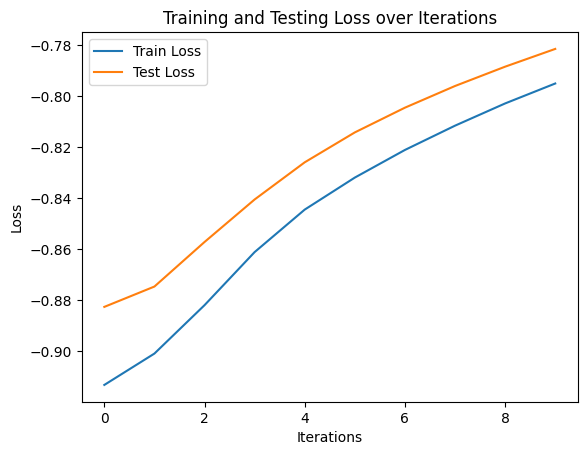

In [ ]:
# Plot Loss
plt.plot(train_loss_values_, label="Train Loss")
plt.plot(test_loss_values_, label="Test Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Iterations")
plt.legend()
plt.show()

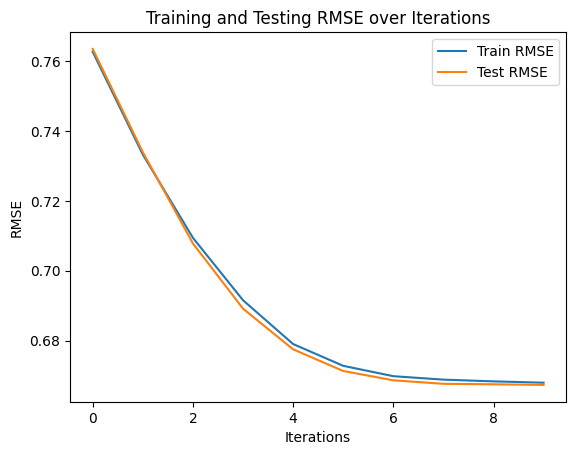

In [ ]:
# Plot RMSE
plt.plot(train_rmse_values_, label="Train RMSE")
plt.plot(test_rmse_values_, label="Test RMSE")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Training and Testing RMSE over Iterations")
plt.legend()
plt.show()


# Plotting

In [ ]:
import seaborn as sns

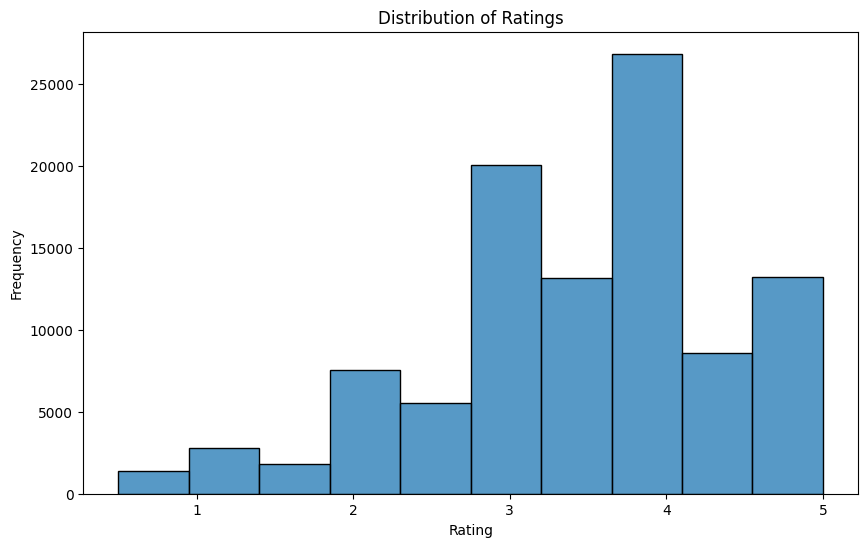

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['rating'], bins=10)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.savefig("distribution_of_ratings.pdf", format='pdf')
plt.show()

In [ ]:
# number of ratings each movie has received
dgree_counts = data['movieId'].value_counts()
# frequency of each rating
Clusters = dgree_counts.value_counts().sort_index()

x = Clusters.index
y = Clusters.values

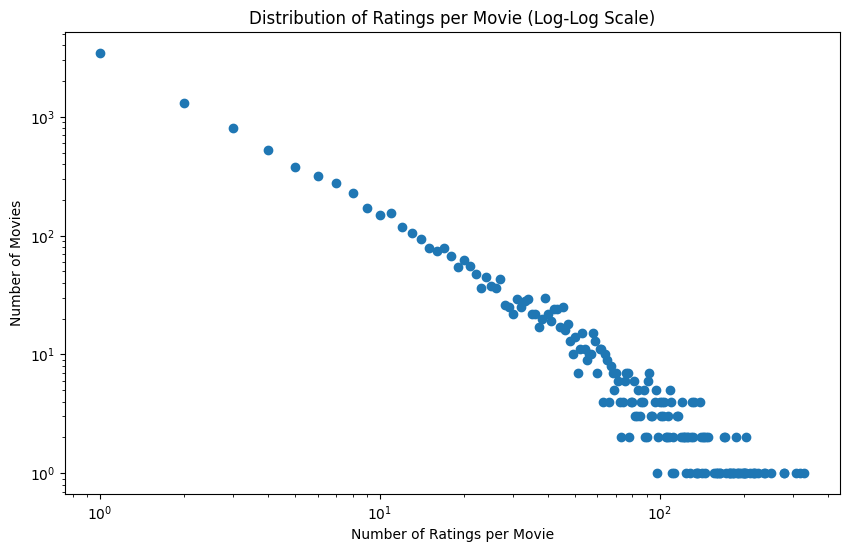

In [ ]:
plt.figure(figsize=(10, 6))
plt.loglog(x, y, marker='o', linestyle='None')
plt.title('Distribution of Ratings per Movie (Log-Log Scale)')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')
plt.savefig("Distribution_of_Ratings_per_Movie_(Log-Log_Scale).pdf", format='pdf')

plt.show()

<ipython-input-60-efe2d24650b4>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=genres, order=genres.value_counts().index, palette="viridis")


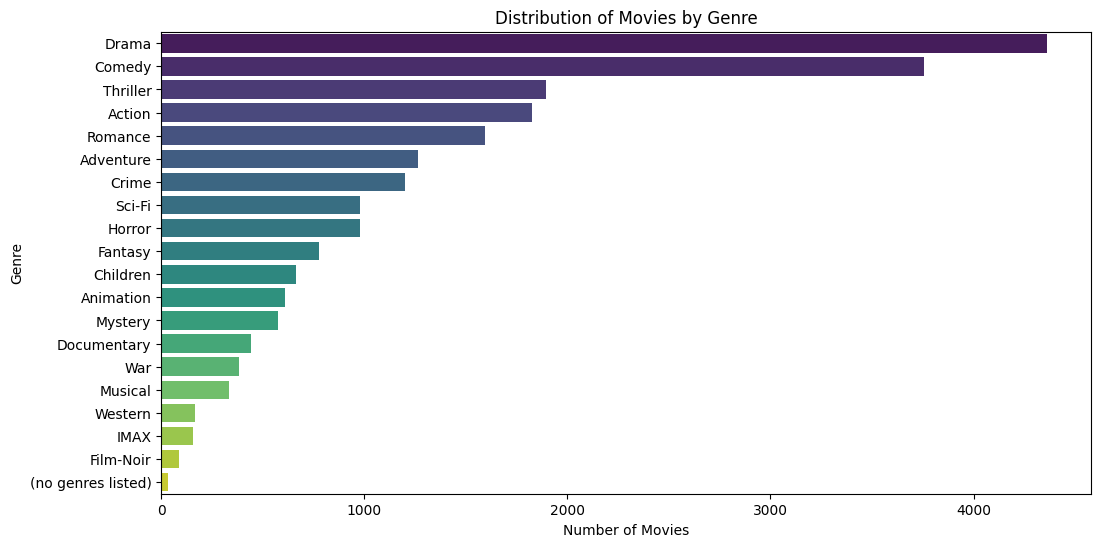

In [ ]:
movies_data = pd.read_csv('/content/drive/MyDrive/data/1m/movies.csv')

genres = movies_data['genres'].str.split('|').explode()

# Plot the distribution of genres
plt.figure(figsize=(12, 6))
sns.countplot(y=genres, order=genres.value_counts().index, palette="viridis")
plt.title('Distribution of Movies by Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.savefig("Distribution_of_Movies_by_Genre.pdf", format='pdf')
plt.show()

<ipython-input-61-2950326e89c2>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating_by_genre.values, y=avg_rating_by_genre.index, palette="coolwarm")


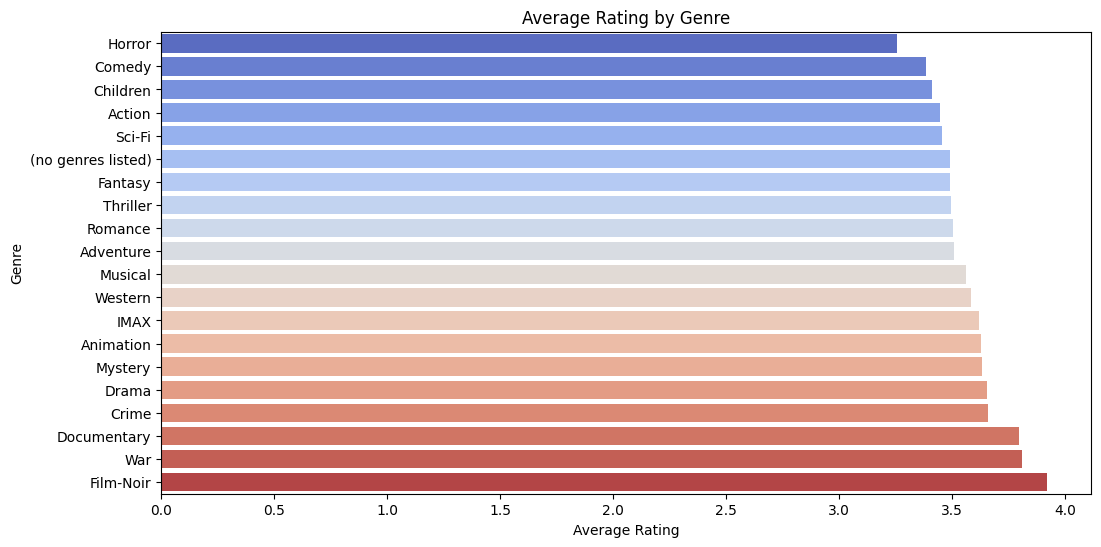

In [ ]:
# Load ratings data
ratings_data = pd.read_csv('/content/drive/MyDrive/data/1m/ratings.csv')

merged_data = pd.merge(ratings_data, movies_data, on='movieId')

merged_data['genres'] = merged_data['genres'].str.split('|')
merged_data_exploded = merged_data.explode('genres')
avg_rating_by_genre = merged_data_exploded.groupby('genres')['rating'].mean().sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_rating_by_genre.values, y=avg_rating_by_genre.index, palette="coolwarm")
plt.title('Average Rating by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.savefig("Average_Rating_by_Genre.pdf", format='pdf')
plt.show()


<ipython-input-62-136cdfa90c62>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_count_by_genre.values, y=rating_count_by_genre.index, palette="magma")


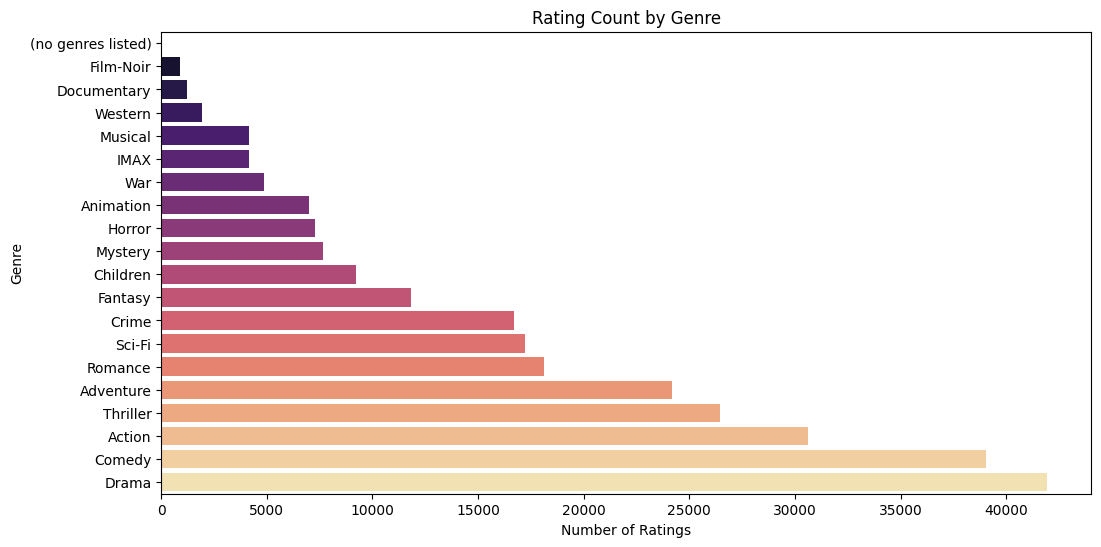

In [ ]:
rating_count_by_genre = merged_data_exploded.groupby('genres')['rating'].count().sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x=rating_count_by_genre.values, y=rating_count_by_genre.index, palette="magma")
plt.title('Rating Count by Genre')
plt.xlabel('Number of Ratings')
plt.ylabel('Genre')
plt.savefig("Rating_Count_by_Genre.pdf", format='pdf')
plt.show()


<ipython-input-63-c930955671b1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=movie_rating_counts.index, x=movie_rating_counts.values, palette="Blues_d")


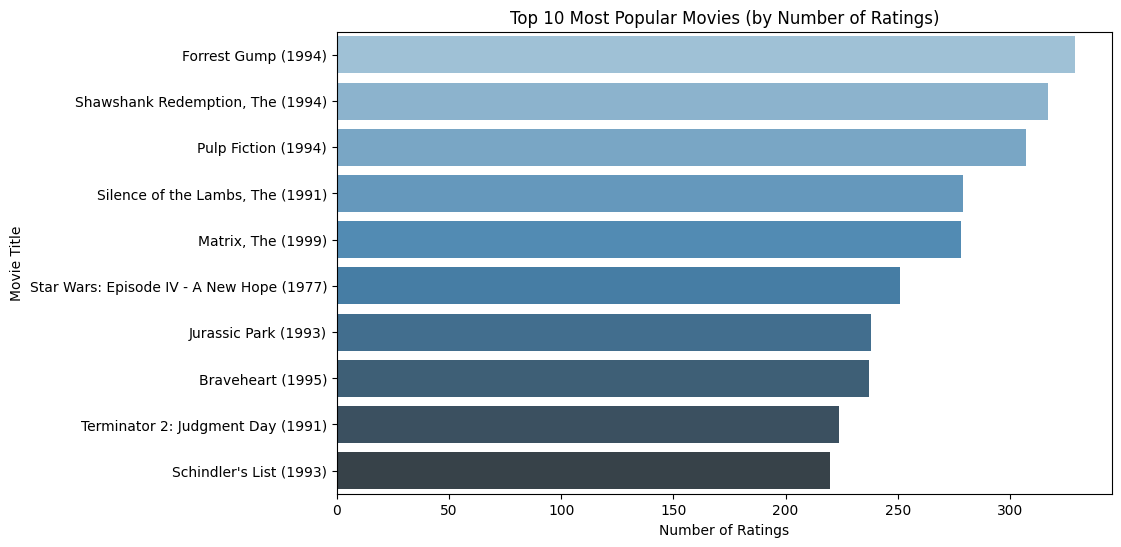

In [ ]:
# Calculate the number of ratings per movie
movie_rating_counts = merged_data.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

# Plot the top 10 most rated movies
plt.figure(figsize=(10, 6))
sns.barplot(y=movie_rating_counts.index, x=movie_rating_counts.values, palette="Blues_d")
plt.title('Top 10 Most Popular Movies (by Number of Ratings)')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.savefig("Top_10_Most_Popular_Movies_(by_Number_of_Ratings).pdf", format='pdf')
plt.show()